<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<H3 align='center'> Sección 1 - Sentiment Analysis en Texto </H3>
<hr style="height:2px;border:none"/>
<center>
    <h4> Sebastián Godínez San Martín, 201673520-8</h4>
    <h4> Daniel Toro, 201673595-K </h4> 
</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud
que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un
tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad
de un trozo de texto, es decir, clasificar una determinada evaluación escrita (*review*), en que una persona
manifiesta una opinión, como *positiva*, *negativa* o *neutral*. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.  La dificultad de este problema radica en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las personas ası́ como el manejo de negaciones, sarcasmo y abreviaciones en una frase.

<img src="https://formtitanhelpdeskimage.s3.amazonaws.com/70c78f9df2fd5c130e7021644f78f4c5.jpg" title="Title text" width="40%" />


Los datos que usaremos para esta actividad corresponden a un subconjunto de los datos publicados en **Kaggle**,  en  el  contexto  de  una  competencia  organizada  por  la  Universidad  de  Stanford  [[2]](#refs).   Cada  registro disponible corresponderá a una opinión sobre una película, registrada sobre el sitio *Rotten Tomatoes*.  Para empezar  nos  limitaremos  a  estudiar  textos  anotados  como  positivos  o  negativos,  clases  que  codificaremos como +1 y 0 respectivamente. Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget -O train_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train
wget -O test_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev
```

> Cargue los dos conjuntos de datos a ser trabajados, donde la etiqueta ya viene codificada y la dejaremos como negativo (0) y positivo (1).

In [2]:
# train data
ftr = open("train_data.csv", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = (pd.to_numeric(df_train['Sentiment'])+1)/2 # 0 o 1
# test data
fts = open("test_data.csv", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_test['Sentiment'] = (pd.to_numeric(df_test['Sentiment'])+1)/2 # 0 o 1

df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values

> a) Describa los datos trabajados, como la cantidad de datos en cada conjunto, largo de los textos, la cantidad de ejemplo por cada clase, o alguna otra forma que piense que pueda ser útil para comprender el problema trabajado.

In [3]:
print(f"Estructura: \n{pd.concat([df_train, df_train['Text'].str.len()], sort=False, axis=1)}")

Estructura: 
      Sentiment                                               Text  Text
0           0.0  everything's serious , poetic , earnest and --...    63
1           0.0  narratively , trouble every day is a plodding ...    53
2           1.0  a truly wonderful tale combined with stunning ...    58
3           1.0  jason patric and ray liotta make for one splen...    64
4           0.0  haneke keeps us at arm's length . guided more ...   113
...         ...                                                ...   ...
3549        0.0  it takes a strange kind of laziness to waste t...   152
3550        0.0  an easy watch , except for the annoying demean...    74
3551        1.0  dog soldiers doesn't transcend genre -- it emb...   110
3552        0.0  it uses the pain and violence of war as backgr...    72
3553        1.0  victor rosa is leguizamo's best movie work so ...    99

[3554 rows x 3 columns]


In [4]:
# cantidad datos positivos y negativos
print(f"Tamaño conjunto entrenamiento: {df_train.shape}")
print(df_train.Sentiment.value_counts())
print(f"Tamaño conjunto testeo: {df_test.shape}")
print(df_test.Sentiment.value_counts())

Tamaño conjunto entrenamiento: (3554, 2)
0.0    1784
1.0    1770
Name: Sentiment, dtype: int64
Tamaño conjunto testeo: (3554, 2)
0.0    1803
1.0    1751
Name: Sentiment, dtype: int64


In [5]:
print("Información de los textos:")
print("--------Entrenamiento--------")
print(df_train["Text"].str.len().describe())
print("--------Test--------")
print(df_test["Text"].str.len().describe())

Información de los textos:
--------Entrenamiento--------
count    3554.000000
mean      114.707091
std        51.523887
min         7.000000
25%        76.000000
50%       111.000000
75%       150.750000
max       267.000000
Name: Text, dtype: float64
--------Test--------
count    3554.000000
mean      116.467923
std        51.504231
min         9.000000
25%        78.000000
50%       114.000000
75%       151.000000
max       268.000000
Name: Text, dtype: float64


De los datos obtenidos en el conjunto de entrenamiento, 1784 corresponden a opiniones negativas y 1770 a opiniones positivas.

> b) Construya un conjunto de validación desde el conjunto de entrenamiento para seleccionar modelos. Decida el tamaño dada la cantidad de ejemplos que se tienen para entrenamiento.

In [6]:
from sklearn.model_selection import train_test_split
df_train_text, df_val_text, labels_train, labels_val  = train_test_split(df_train_text,
                                                                         labels_train, test_size= int(df_train.shape[0]*0.3),
                                                                         random_state=0)
print(f"Tamaño conjunto entrenamiento: {df_train_text.shape} \nTamaño conjunto validacion: {df_val_text.shape}")

Tamaño conjunto entrenamiento: (2488,) 
Tamaño conjunto validacion: (1066,)


De el conjunto de entrenamiento de 3554 se tomara el 30% para ser datos de validación, es decir, finalmente tenemos 2488 datos de entrenamiento y 1066 datos de validación.

> c) Realice un pre-procesamiento a los textos para normalizar un poco su estructura, para ello utilice el código de ejemplo a continuación, donde se pasa el texto a minúsculas (*lower-casing*), se reducen las mútliples letras, se eliminan palabras sin significados como artículos, pronombres y preposiciones (*stop word removal* [[3]](#refs)), además de pasar las palabras a su tronco léxico con la técnica de *lemmatizer* [[4]](#refs). Comente la importancia de un correcto pre-procesamiento en el domino de lenguaje natural.

In [47]:
# EJECUTAR EN TERMINAL
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 

def word_extractor(text, func=base_word):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text) #substitute multiple letter by two
    words = ""
    wordtokens = [ func(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" " + word
    return words

# ejemplos
print(word_extractor("I love to eat cake"))
print(word_extractor("I love eating cake"))
print(word_extractor("I loved eating the cake"))
print(word_extractor("I do not love eating cake"))
print(word_extractor("I don't loooove eating cake"))

# pre-procesamiento sobre la data
texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

print("Comparacion primer caso de entrenamiento:")
print(df_train_text[3065])
print(texts_train[0])

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't loove eating cake
Comparacion primer caso de entrenamiento:
the irwins emerge unscathed , but the fictional footage is unconvincing and criminally badly acted .

 irwins emerge unscathed , fictional footage unconvincing criminally badly acted .


La idea de este paso es reducir la cantidad de palabras que tendra cada ejemplo, esto se debe a varias razones. La primera es que existen palabras que no agregan valor al analisis y la segunda razon es que para poder entrenar nuestra maquina es necesario pasar el texto a vector por lo que reducir la cantidad de palabras a trabajar puede reducir la dimensionalidad de nuestra matriz.

> d) Construya una representación vectorial a los textos de entrada para poder ser manejados y clasificados por los modelos de aprendizaje. Para ésto utilice el tipo de característica más común, que consiste en contar cuántas veces aparece cada términos/palabras en el texto, denominado **TF** (*term-frequency*). Para esto, se necesita contar con un vocabulario base, el cual se construirá a través de la unión de todas las palabras que observemos en los textos de entrenamiento ¿Cuáles son las palabras más frecuentes?

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(texts_train)
vectorizer.transform(texts_train)

#transform val and test
# se transforma a partir del fit hecho por la data de training
features_train = vectorizer.transform(texts_train)
features_val = vectorizer.transform(texts_val)
features_test = vectorizer.transform(texts_test)

print(f"Largo entrenamiento: {features_train.shape}")
print(f"Largo validacion: {features_val.shape}")
print(f"Largo testeo: {features_test.shape}")

# ver palabras más frecuentes
vocab = vectorizer.get_feature_names()
def frecuentes(vector):
    
    dist = vector.sum(axis=0)

    frecuencia = [(word, dist[0, i]) for word, i in vectorizer.vocabulary_.items()]
    return sorted(frecuencia, key = lambda x: x[1], reverse=True)[0:20]

print(f"Frecuencia de Training:\n{frecuentes(features_train)}")
print("---------------------------------------")
print(f"Frecuencia de Validación:\n{frecuentes(features_val)}")
print("---------------------------------------")
print(f"Frecuencia de Testing:\n{frecuentes(features_test)}")

Largo entrenamiento: (2488, 7971)
Largo validacion: (1066, 7971)
Largo testeo: (3554, 7971)
Frecuencia de Training:
[('film', 423), ('movie', 349), ('one', 182), ('like', 166), ('ha', 164), ('make', 141), ('story', 128), ('character', 120), ('good', 105), ('even', 104), ('comedy', 95), ('way', 94), ('time', 93), ('well', 88), ('performance', 86), ('work', 85), ('much', 84), ('doe', 82), ('director', 80), ('little', 79)]
---------------------------------------
Frecuencia de Validación:
[('film', 161), ('movie', 154), ('like', 89), ('one', 77), ('ha', 71), ('time', 55), ('comedy', 52), ('doe', 50), ('good', 49), ('story', 49), ('make', 45), ('much', 45), ('character', 45), ('even', 40), ('life', 40), ('feel', 33), ('work', 32), ('well', 30), ('performance', 30), ('never', 28)]
---------------------------------------
Frecuencia de Testing:
[('film', 581), ('movie', 568), ('one', 259), ('ha', 246), ('like', 239), ('story', 204), ('character', 178), ('time', 176), ('make', 167), ('good', 14

Luego de ordenar el vector suma, se despliega las 20 palabras mas repetidas. Observando que muchas de ellas no aportan información en el análisis, como lo sos las palabras _movie_, _film_, entre otras palabras ya que son muy generales. Notar que entre los 3 conjuntos se repiten las mismas palabras.

> e) Para tener una visión distinta y entender mejor la representación vectorial realizada, visualice los datos en un plano 2D. Para ésto utilice la técnica **LSA** (*Latent Semantic Analysis*) [[5]](#refs) que a diferencia de PCA, **no centra** los datos antes de realizar la descomposicipon SVD, de ésta manera podrá visualizar el espacio semántico de "conceptos" latentes usados en la representación. Coloree cada texto en base a su clase ¿Qué indica lo observado? Comente e interprete los resultados

No handles with labels found to put in legend.


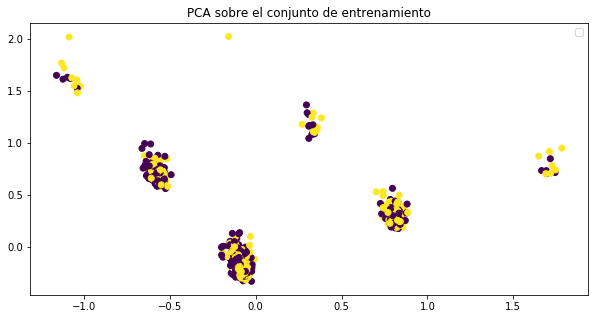

In [9]:
from sklearn.decomposition import PCA
model = PCA(n_components=2)
model.fit(features_train.toarray())
x_plot = model.transform(features_train.toarray())
plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c=labels_train)
plt.title("PCA sobre el conjunto de entrenamiento")
plt.legend()
plt.show()

Con fines educacionales realizamos PCA obteniendo que no es linealmente separable.

No handles with labels found to put in legend.


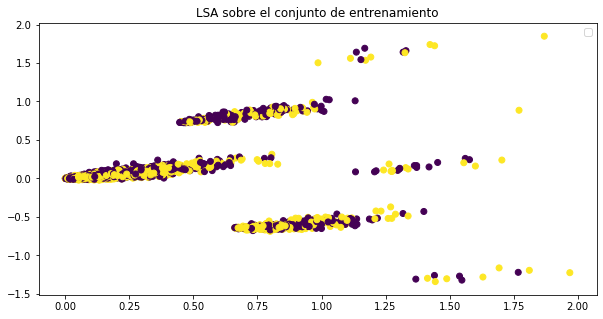

In [10]:
from sklearn.decomposition import TruncatedSVD
model = TruncatedSVD(n_components=2)
model.fit(features_train)
x_plot = model.transform(features_train)
plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c=labels_train)
plt.title("LSA sobre el conjunto de entrenamiento")
plt.legend(loc='best')
plt.show()

Se observa que no es linealmente separable, saludos.

> f) Entrene un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$). Varíe el parámetro de regularización $C$, en potencias de 10, midiendo el error de predicción obtenido sobre los datos de entrenamiento y validación, construya un gráfico que muestre la variación de ambos errores respecto al parámetro $C$. Explique el significado y valor esperado del parámetro de regularización.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Text(0.5, 1.0, 'Regresión Logistica Regularizada\nPrecisión de Validación y Prueba v/s C')

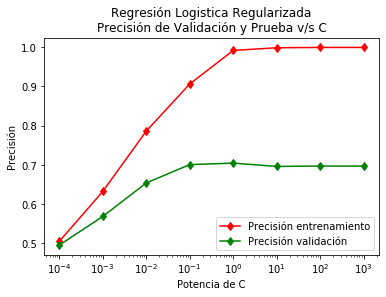

In [11]:
from sklearn.linear_model import LogisticRegression

def do_LOGIT(x,y,xv,yv, param):
    #print("Param C= ",param)
    model= LogisticRegression(penalty='l2', solver='saga')
    model.set_params(C=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

Cs = [10**int(i) for i in np.arange(-4,4)]

trains_acc = list()
tests_acc = list()
for c in Cs:
    _, train_acc, test_acc = do_LOGIT(features_train,labels_train,features_val,labels_val, param= c)
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    
plt.plot(Cs, trains_acc, 'rd-', label="Precisión entrenamiento")
plt.plot(Cs, tests_acc, 'gd-', label="Precisión validación")
plt.legend(loc='best')
plt.xlabel("Potencia de C")
plt.ylabel("Precisión")
plt.xscale('log',basex=10)
plt.title("Regresión Logistica Regularizada\nPrecisión de Validación y Prueba v/s C")

> g) Entrene una Máquina de Soporte Vectorial (SVM) con distintos kernels. Similar a lo anterior, construya un gráfico que muestre la variación de ambos errores respecto al parámetro de regularización $C$ para cada tipo de kernel que experimente. Explique el significado y valor esperado de los parámetros en este modelo.

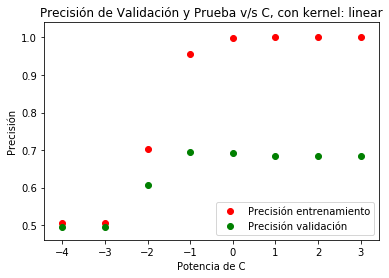

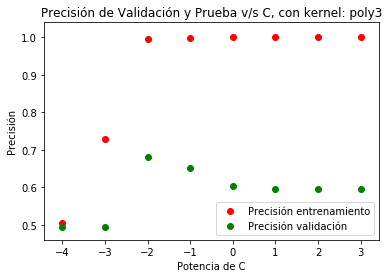

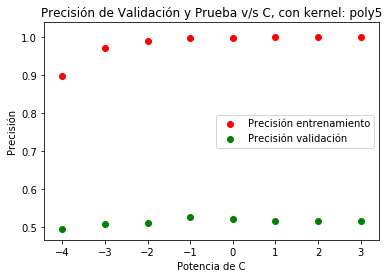

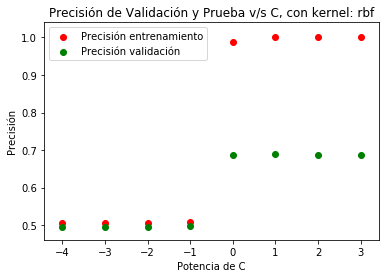

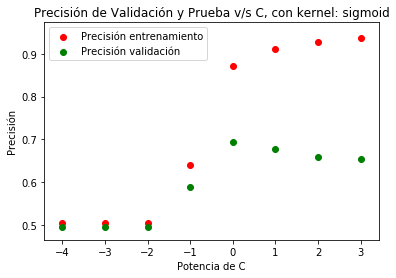

In [12]:
from sklearn.svm import SVC as SVM #SVC is for classification
def do_SVM(x,y,xv,yv, param, kernel='linear', d = 3, probability=False):
    #print("Param C= ",C, 'Kernel= ', kernel)
    model= SVM()
    if kernel == 'poly':
        model.set_params(C=param,kernel=kernel, degree = d, gamma=0.5, probability=probability)
    else:
        model.set_params(C=param,kernel=kernel, probability=probability) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

kernels = ['linear', 'poly3', 'poly5', 'rbf', 'sigmoid']
Cs = [10**int(i) for i in np.arange(-4,4)]

for kernel in kernels:
    trains_acc = list()
    tests_acc = list()
    for c in Cs:
        if 'poly' in kernel:
            _, train_acc, test_acc = do_SVM(features_train,
                                           labels_train,
                                           features_val,
                                           labels_val,
                                           param= c,
                                           kernel='poly',
                                           d=int(kernel[-1])) # grado de ser polinomio
        else:
            _, train_acc, test_acc = do_SVM(features_train,
                                           labels_train,
                                           features_val,
                                           labels_val,
                                           param= c,
                                           kernel=kernel)
        trains_acc.append(train_acc)
        tests_acc.append(test_acc)

    fig, ax = plt.subplots()
    ax.scatter(np.arange(-4,4), trains_acc, color='red', label="Precisión entrenamiento")
    ax.scatter(np.arange(-4,4), tests_acc, color='green', label="Precisión validación")
    ax.legend(loc='best')
    ax.set_xlabel("Potencia de C")
    ax.set_ylabel("Precisión")
    ax.set_title(f"Precisión de Validación y Prueba v/s C, con kernel: {kernel}")

plt.show()

> h) Utilice el algoritmo de similaridad k-NN para intentar resolver el problema. Varíe el parámetro de los vecinos $k$ en un rango que estime conveniente y realice graficos de errores como en las preguntas anteriores. Comente sobre el valor esperado de este parámetro.

Text(0.5, 1.0, 'k-NN\nPrecisión de Validación y Prueba v/s Numero de Vecinos')

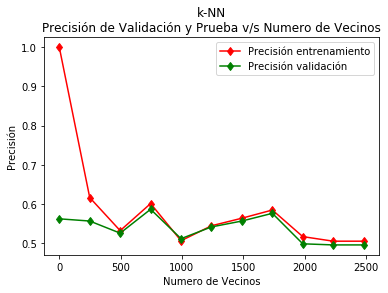

In [13]:
from sklearn.neighbors import KNeighborsClassifier

def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    #print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

# tomaremos 10 casos
steps = int(features_train.shape[0]/10)
Ks = np.arange(1, features_train.shape[0], steps)

trains_acc = list()
tests_acc = list()
for k in Ks:
    _, train_acc, test_acc = do_KNN(features_train,labels_train,features_val,labels_val, param= k)
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    
plt.plot(Ks, trains_acc, 'rd-', label="Precisión entrenamiento")
plt.plot(Ks, tests_acc, 'gd-', label="Precisión validación")
plt.legend(loc='best')
plt.xlabel("Numero de Vecinos")
plt.ylabel("Precisión")
plt.title("k-NN\nPrecisión de Validación y Prueba v/s Numero de Vecinos")

> i) Entrene un Arbol de Decisión para resolver el problema. Varíe los parámetros de *max depth* y *min samples split* de manera separada, constuyendo gráficos de error respecto a estos parámetros. *Los valores que se presentan son sugerencias, no es necesario utilizar los mismos*. Comente sobre la diferencia entre la selección de estos dos parámetros.

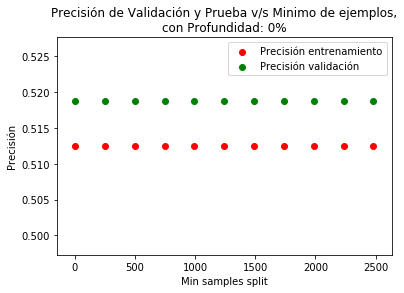

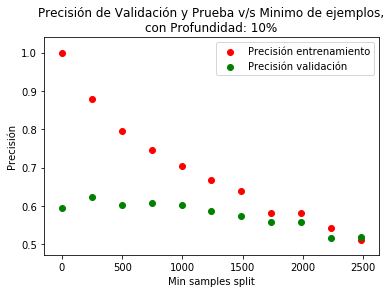

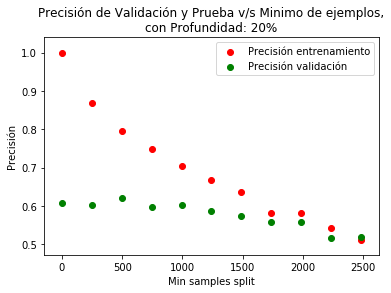

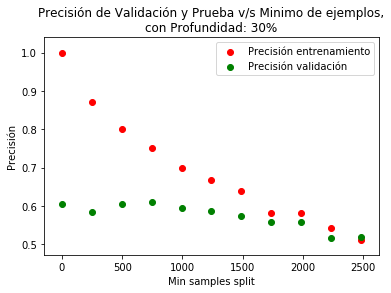

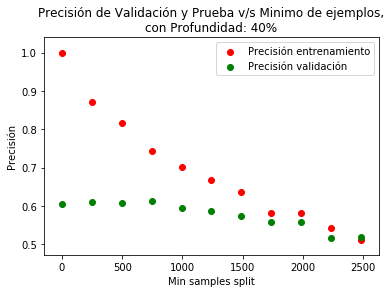

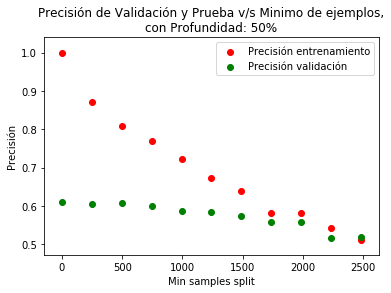

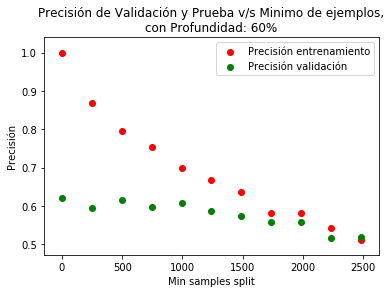

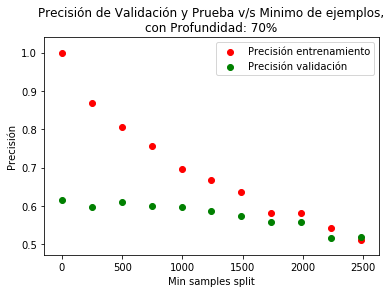

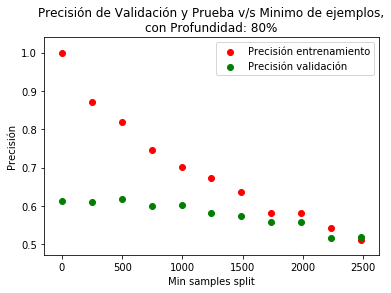

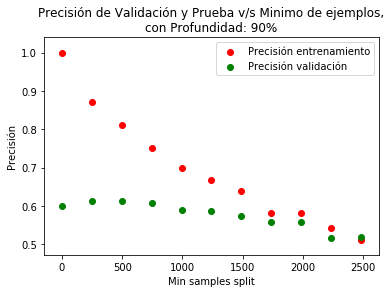

In [14]:
from sklearn.tree import DecisionTreeClassifier as Tree
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    #print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

# similar a los otros casos se tomaran 10 casos para cada uno
stepsd = int(features_train.shape[1]/10)
stepss = int(features_train.shape[0]/10)
Depths = np.arange(1, features_train.shape[1], stepsd ) #choose steps
SamplesS = np.arange(2, features_train.shape[0] , stepss ) #choose steps

for Depth in Depths:
    trains_acc = list()
    tests_acc = list()
    for Sample in SamplesS:
        _, train_acc, test_acc = do_Tree(features_train,labels_train,features_val,labels_val, param_d= Depth, param_m=Sample)
        trains_acc.append(train_acc)
        tests_acc.append(test_acc)
    # ploteo
    fig, ax = plt.subplots()
    ax.scatter(SamplesS, trains_acc, color='red', label="Precisión entrenamiento")
    ax.scatter(SamplesS, tests_acc, color='green', label="Precisión validación")
    ax.legend(loc='best')
    ax.set_xlabel("Min samples split")
    ax.set_ylabel("Precisión")
    profundidad = int(Depth/features_train.shape[1] * 100)
    ax.set_title(f"Precisión de Validación y Prueba v/s Minimo de ejemplos,\ncon Profundidad: {profundidad}%")

plt.show()

> j) Utilice una Red Neuronal Artificial (ANN) para intentar resolver el problema, como la que se señala a continuación (utilizando el framework de *keras*): entrenada por 25 iteraciones al dataset (*epochs*) con un tamaño de *batch* de 128 para las actualizaciones de los pesos, utilizando *SGD* con una tasa de aprendizaje $0.1$ sobre la función de pérdida binaria de clasificación. La arquitectura de la red contiene una capa de salida con una única neurona que indica la probabilidad de que el texto sea positivo, una capa escondida con número de neuronas $N_h$ y la capa de entrada implícita para $x$. Varíe el parámetro que corresponde al número de neuronas en la capa oculta $N_h$, en potencias de 2, y vuelva a realizar el gráfico de error con respecto al parámetro. Comente.

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

Text(0.5, 1.0, 'ANN\nPrecisión de Validación y Prueba v/s n° Neuronas')

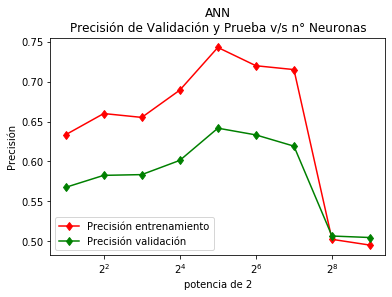

In [15]:
# instalar tensorFlow
# instalar launchpadlib
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def do_ANN(x,y, xv,yv, param):
    #print("Neuron hidden = ",param)
    model = Sequential()
    model.add(Dense(units=param, input_dim=x.shape[1], activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x, y, epochs=25, batch_size=128, verbose=0)
    train_acc = model.evaluate(x,y, verbose=0)[1] #in position 0 is the loss
    test_acc = model.evaluate(xv,yv, verbose=0)[1]
    return model, train_acc, test_acc

N_hs = [2**i for i in range(1,10)]

trains_acc = list()
tests_acc = list()
for N_h in N_hs:
    _, train_acc, test_acc = do_ANN(features_train,labels_train,features_val,labels_val, param= N_h)
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    
plt.plot(N_hs, trains_acc, 'rd-', label="Precisión entrenamiento")
plt.plot(N_hs, tests_acc, 'gd-', label="Precisión validación")
plt.legend(loc='best')
plt.xlabel("potencia de 2")
plt.ylabel("Precisión")
plt.xscale('log',basex=2)
plt.title("ANN\nPrecisión de Validación y Prueba v/s n° Neuronas")

> k) Ahora evalúe sobre el conjunto de pruebas el mejor modelo obtenido, seleccionado en base a la métrica de desempeño en el conjunto de validación. Comente sobre la calidad obtenida en el problema trabajado ¿Es un buen valor? ¿Cuál podría ser un valor de referencia?

In [16]:
model, _, _ = do_SVM(features_train,
                       labels_train,
                       features_val,
                       labels_val,
                       probability = True,
                       param= 10**-2,
                       kernel='poly',
                       d=3) # grado de ser polinomio

> l) Para comparar sus resultados utilice el modelo VADER (*Valence Aware Dictionary and sEntiment Reasoner*) [[6]](#refs), el cual entrega una *score* de predicción a nivel léxico (de palabras que comúnmente se asocian a una orientiación positiva o negativa). Este modelo construido manualmente no requiere entrenamiento, por lo que solo debe evaluar en conjunto de pruebas realizando predicciones del texto bruto (sin pre-procesamiento). Comente.

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
def vader_predict(sentences): 
    sid_obj = SentimentIntensityAnalyzer() 
    sent_v = []
    for text in sentences:
        sentiment_dict = sid_obj.polarity_scores(text) 
        if sentiment_dict["pos"] > sentiment_dict["neg"]: #based on scores
            sent_v.append(1)
        else:
            sent_v.append(0)
    return np.asarray(sent_v)
vader_pred_test = vader_predict(df_test_text) 
from sklearn.metrics import accuracy_score
print(f"Precisión obtenida usando VADER: {accuracy_score(labels_test, vader_pred_test)}")

Precisión obtenida usando VADER: 0.6359032076533483


> m) Bajo la idea del modelo VADER realice un análisis de qué palabras su modelo tiende a considerar como positivas o negativas por si solas. Algunos de los modelos estudiados en esta sección realizan una predicción probabilista, utilice uno de éstos para verificar lo solicitado. Sobre la representación *TF* genere datos de entradas que contengan una sola palabra del vocabulario para evaluar que predicción les genera su modelo a esas palabras. Muestre las palabras más negativas y positivas en el vocabulario consideradas por su modelo. Comente.

In [18]:
V = len(vocab)
word_scores = np.zeros((V, 2))
for i in range(V):
    x_word = np.zeros((1, V))
    x_word[:,i] = 1 # only the "i" word appeared
    word_scores[i] = model.predict_proba(x_word)
word_scores

array([[0.5       , 0.5       ],
       [0.51027214, 0.48972786],
       [0.5       , 0.5       ],
       ...,
       [0.50513258, 0.49486742],
       [0.50530803, 0.49469197],
       [0.50617022, 0.49382978]])

> n) Intente mejorar los resultados de otra manera. Varíe el pre-procesamiento realizado a los datos en c), por ejemplo eliminar símbolos, números o aplicar la técnica de *stemmming* [[7]](#refs) en lugar de *lemmatization* para llevar a su tronco léxico.

In [48]:
from nltk.stem.porter import PorterStemmer
def word_stemming(word):
    wordstemmer = PorterStemmer()
    return wordstemmer.stem(word)

# ejemplos
print(word_extractor("I love to eat cake", word_stemming))
print(word_extractor("I love eating cake", word_stemming))
print(word_extractor("I loved eating the cake", word_stemming))
print(word_extractor("I do not love eating cake", word_stemming))
print(word_extractor("I don't loooove eating cake", word_stemming))

# pre-procesamiento sobre la data
texts_train_n = [word_extractor(text, word_stemming) for text in df_train_text]
texts_val_n = [word_extractor(text, word_stemming) for text in df_val_text]
texts_test_n = [word_extractor(text, word_stemming) for text in df_test_text]

def comparacion(a, b):
    return pd.concat([pd.Series(a), pd.Series(b)], sort=False, axis=1)
print(f"Comparación Entrenamiento:\n{comparacion(texts_train, texts_train_n)}")

 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't loov eat cake
Comparación Entrenamiento:
                                                      0  \
0      irwins emerge unscathed , fictional footage u...   
1      others , attuned anarchist maxim 'the urge de...   
2                 compelling wiseman epic recent year .   
3      aimlessly unsuccessfully attempt fuse least t...   
4      koepp 's screenplay n't nearly surprising cle...   
...                                                 ...   
2483                   nervous breakdown entertaining .   
2484                  kind trifle date night invented .   
2485   spielberg 's picture smarter subtler [ total ...   
2486           fine acting sense connecting dot , dot .   
2487   think lion king redone horse , fewer delibera...   

                                                      1  
0      irwin emerg unscath , fiction footag unconvin...  
1      , attun anarchist maxim 'the urg destroy also...  
2          

> o) Varíe la representación utilizada actualmente por alguna otra que ayude a mejorar el desempeño, por ejemplo reducir el peso de una palabra si es que aparece en muchos textos: TF-IDF. Existen varias opciones que podría realizar para mejorar el desempeño, por ejemplo reducir el vocabulario a las $K$ palabras más frecuentes, eliminar las palabras menos frecuentes, normalizar la representación, utilizar *n-gramas*, entre otras.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(binary=False, 
                              ngram_range=(1, 1), 
                              max_df=1.0, 
                              min_df=1, 
                              max_features=None, 
                              norm='l2', 
                              use_idf=True, 
                              sublinear_tf=False)
tfidf_model.fit(texts_train_n)
features_train_n = tfidf_model.transform(texts_train_n)
features_val_n = tfidf_model.transform(texts_val_n)
features_test_n = tfidf_model.transform(texts_test_n)

print(f"Comparacion largo matrices de entrenamiento:\n{features_train.shape}, {features_train_n.shape}")

Comparacion largo matrices de entrenamiento:
(2488, 7971), (2488, 6621)


> p) Utilice métricas auxiliares para entender en qué falla su mejor modelo obtenido hasta el momento. ¿La información entregada indica cómo se podría mejorar o cual sería la causa de la falla?

In [30]:
from sklearn.metrics import classification_report
def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model.predict(x), target_names=['-','+']))
score_the_model(model, features_test, labels_test )

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.51      0.99      0.67      1803
           +       0.60      0.01      0.02      1751

    accuracy                           0.51      3554
   macro avg       0.55      0.50      0.35      3554
weighted avg       0.55      0.51      0.35      3554



> q) Algo que se puede modificar en algunos modelos de aprendizaje es poner peso en cada una de las clases, por ejemplo si una clase es de mayor interés que las otras e interesa reducir más su error. En *sklearn* ésto puede ser realizado con el parámetro de *class_weights*. Por ejemplo, asigne que detectar los textos negativos me interesa 5 veces más que detectar los textos positivos. Comente.

In [22]:
classes_weights = {0: 5, 1: 1} #or choose..
model.set_params(class_weight=classes_weights)
model.fit(features_train, labels_train)
score_the_model(model, features_test, labels_test)

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.51      0.99      0.67      1803
           +       0.60      0.01      0.02      1751

    accuracy                           0.51      3554
   macro avg       0.55      0.50      0.35      3554
weighted avg       0.55      0.51      0.35      3554



> r) Visualice la clasificación que realiza su mejor modelo sobre algunos textos de pruebas ¿Qué entega mas información, una predicción categórica o una continua? ¿Cuál podría ser el beneficio de una o de otra? Comente

In [23]:
test_pred = model.predict_proba(features_test) #or ".predict"
spl = np.random.randint( 0, len(test_pred), size=15)
for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    print("True sent: ", true_s, "-- Pred sent: ",pred_s)
    print("Raw text: ", text)

True sent:  1.0 -- Pred sent:  [0.54445668 0.45554332]
Raw text:  the success of undercover brother is found in its ability to spoof both black and white stereotypes equally .

True sent:  0.0 -- Pred sent:  [0.5667358 0.4332642]
Raw text:  a sermonizing and lifeless paean to teenage dullards .

True sent:  0.0 -- Pred sent:  [0.56139933 0.43860067]
Raw text:  this angst-ridden territory was covered earlier and much better in ordinary people .

True sent:  1.0 -- Pred sent:  [0.5102533 0.4897467]
Raw text:  the story itself it mostly told through on-camera interviews with several survivors , whose riveting memories are rendered with such clarity that it's as if it all happened only yesterday .

True sent:  0.0 -- Pred sent:  [0.50951508 0.49048492]
Raw text:  unintelligible , poorly acted , brain-slappingly bad , harvard man is ludicrous enough that it could become a cult classic .

True sent:  1.0 -- Pred sent:  [0.38135664 0.61864336]
Raw text:  . . . is there a deeper , more direct 

> s) Comente sobre el desempeño obtenido por los diferentes modelos de aprendizaje utilizados al enfrentar el problema, ¿Dónde pareciera estar la mejora? ¿En la variación de los modelos y sus parámetros o en la modificación de la representación? ¿Cuál modelo de aprendizaje le parece mejor en base a su criterio? ya sea desempeño, tiempo de ejecución comodidad en las decisiones involucradas, etc.

## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews  
[3] https://en.wikipedia.org/wiki/Stopwords  
[4] https://en.wikipedia.org/wiki/Lemmatisation  
[5] Landauer, T. K., Foltz, P. W., & Laham, D. (1998). *An introduction to latent semantic analysis*. Discourse processes, 25(2-3), 259-284.  
[6] https://github.com/cjhutto/vaderSentiment  
[7] https://en.wikipedia.org/wiki/Stemming  
[8] Rodrigues, F., Pereira, F., & Ribeiro, B. (2013). *Learning from multiple annotators: distinguishing good from random labelers*. Pattern Recognition Letters, 34(12), 1428-1436.